In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
import itertools
from scipy.optimize import linear_sum_assignment
from IPython.display import clear_output

In [2]:
class Linear():
    def __init__(self, nin, nout):
        self.mat = np.random.normal(0,1,(nin, nout))
        self.bias = np.zeros((1, nout))
    def forward(self, x):
        return np.dot(x, self.mat) + self.bias
    def get_params(self):
        return np.concatenate([self.mat.ravel().copy(), self.bias.ravel().copy()])
    def set_params(self, w):
        self.mat = w[:self.mat.size].reshape(self.mat.shape).copy()
        self.bias = w[self.mat.size:].reshape(self.bias.shape).copy()
    def param_size(self):
        return self.mat.size + self.bias.size
    
class Relu():
    def __init__(self):
        pass
    def forward(self, x):
        return x*(x >= 0)
    def get_params(self):
        return np.array([])
    def set_params(self, w):
        pass
    def param_size(self):
        return 0
    
class Net():
    def __init__(self, sizes):
        self.layers = []
        for a,b in zip(sizes[:-1], sizes[1:]):
            self.layers.append(Linear(a,b))
            self.layers.append(Relu())
        self.layers = self.layers[:-1]
        self.param_sizes = np.cumsum([0] + [l.param_size() for l in self.layers])
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    def get_params(self):
        x = np.concatenate([l.get_params() for l in self.layers])
        return x
    def set_params(self, w):
        for l,a,b in zip(self.layers, self.param_sizes[:-1], self.param_sizes[1:]):
            l.set_params(w[a:b])

In [3]:
x = np.random.normal(0,1,(10,3))
net = Net([3,10,1])
print(net.forward(x))
net.set_params(net.get_params())
print(net.forward(x))

[[ 1.26476994]
 [ 0.40696883]
 [-0.08133308]
 [ 2.41595935]
 [ 0.66537944]
 [-0.14748436]
 [ 1.97363962]
 [ 1.18561444]
 [ 0.33953423]
 [ 0.13456509]]
[[ 1.26476994]
 [ 0.40696883]
 [-0.08133308]
 [ 2.41595935]
 [ 0.66537944]
 [-0.14748436]
 [ 1.97363962]
 [ 1.18561444]
 [ 0.33953423]
 [ 0.13456509]]


In [11]:
pxy = np.array([[0.0,0],[1,0],[2,0],[3,1]])
dxy = np.array([[1.0,1],[2,2]])
bxy = np.array([[0.0,0]])
dth = np.array([3.3,7.7])
mask = np.array([1,1,1,1])

net = Net([4,10,1])
thresh = 2 #84*4

In [136]:
def assign_targets(points_xy, valid_mask, drones_xy, base_xy, drones_death_dist, net, death_thresh):
    if not np.any(valid_mask):
        return np.array([]), np.array([]), np.array([])
    
    points_xy = points_xy[valid_mask]
    
    num_points = points_xy.shape[0]
    num_drones = drones_xy.shape[0]
    # num_drones x num_points
    dist_drn_pnt = np.sqrt(np.sum((points_xy[None,:,:] - drones_xy[:,None,:])**2, axis=2))
    dist_drn_bs = np.sqrt(np.sum((drones_xy - base_xy)**2, axis=1))
    to_base = (dist_drn_bs + death_thresh >= drones_death_dist)
    dist_drn_bs = dist_drn_bs[:,None] + np.zeros_like(dist_drn_pnt)
    dist_pnt_bs = np.sqrt(np.sum((points_xy - base_xy)**2, axis=1))[None,:] + np.zeros_like(dist_drn_pnt)
    death = drones_death_dist[:,None] + np.zeros_like(dist_drn_pnt)
    # num_drones*num_points x 4
    feats = np.hstack([dist_drn_pnt.reshape(-1,1), dist_drn_bs.reshape(-1,1), 
                       dist_pnt_bs.reshape(-1,1), death.reshape(-1,1)])
    # num_drones*num_points x 1
    scores = feats[:,0].reshape((num_drones, num_points))
    #scores = net.forward(feats).reshape((num_drones, num_points))
    
    scores[to_base,:] = np.max(scores) + 1
    drones, points = linear_sum_assignment(scores)
    
    to_base = to_base[drones]
    points[to_base] = -1
    
    tmp = np.arange(valid_mask.size)[valid_mask]
    points = np.array([-1 if p==-1 else tmp[p] for p in points])
    
    fullpoints = - 2 * np.ones(drones_xy.shape[0], dtype=int)
    fullpoints[drones] = points
    
    return drones, points, fullpoints
    
assign_targets(pxy, mask, dxy, bxy, dth, net, thresh)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 91, 93, 94, 95, 96, 97, 98, 99]),
 array([71, 73, 70, 41, 35, 18, 42, 48,  0, 38, 63, -1, 22, 69, 56, 84, 50,
        -1, -1, 57,  1, 80, 34, 58, 16,  9, 54, 94, -1, 95, 89, 92, 36, -1,
        -1, 68,  4, -1, 21, -1, 85, 40, -1, 86, -1, -1, 83, 59, 24, 20, 61,
        46, 87, 52, 15, -1, 97,  8, 13, 78, -1, 81, -1, 72, 64, 60,  2, 14,
        53, 74,  3, 25, 88, 45,  6, 82, 96, 37,  5, 77, 27, 47,  7, 75, 26,
        98, 51, 11, 90, 65, 44, 32, 67, 76]),
 array([71, 73, 70, 41, 35, 18, 42, 48,  0, 38, 63, -1, 22, 69, 56, 84, 50,
        -1, -1, 57,  1, 80, 34, 58, 16,  9, 54, 94, -1, 95, 89, 92, 36, 

In [71]:
fpnt

array([71, 73, 70, 41, 35, 18, 42, 48,  0, 38, 63, -1, 22, 69, 56, 84, 50,
       -1, -1, 57,  1, 80, 34, 58, 16,  9, 54, 94, -1, 95, 89, 92, 36, -1,
       -1, 68,  4, -1, 21, -1, 85, 40, -1, 86, -1, -1, 83, 59, 24, 20, 61,
       46, 87, 52, 15, -1, 97,  8, 13, 78, -1, 81, -1, 72, 64, -2, -2, 60,
        2, 14, -2, 53, 74,  3, 25, 88, 45,  6, 82, 96, 37,  5, 77, 27, 47,
        7, 75, 26, 98, -2, -2, 51, -2, 11, 90, 65, 44, 32, 67, 76])

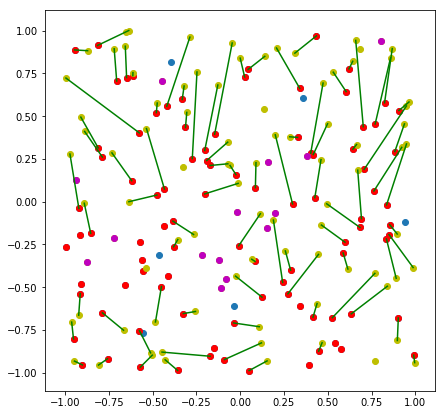

In [70]:
pxy = np.random.uniform(-1,1,(100,2))
dxy = np.random.uniform(-1,1,(100,2))
bxy = np.array([[0.0,0]])
dth = np.random.binomial(1, 0.8, dxy.shape[0])*10000
mask = np.random.binomial(1, 0.9, pxy.shape[0]).astype(bool)
thresh = 0.5

net = Net([4,10,1])

drones, points, fpnt = assign_targets(pxy, mask, dxy, bxy, dth, net, thresh)

plt.figure(figsize=(7,7))
plt.scatter(pxy[:,0], pxy[:,1])
plt.scatter(pxy[mask][:,0], pxy[mask][:,1], color='r')
plt.scatter(dxy[:,0], dxy[:,1], color='y')
plt.scatter(dxy[drones][points==-1,0], dxy[drones][points==-1,1], color='m')

for i,p in enumerate(points):
    if p!=-1:
        plt.plot([pxy[p][0], dxy[drones][i][0]],[pxy[p][1], dxy[drones][i][1]], 'g')

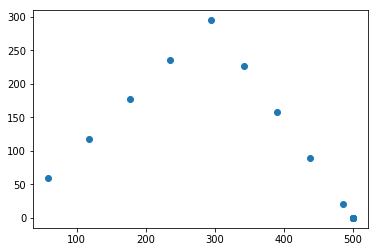

In [147]:
class Drone():
    def __init__(self, xy, speed=13.88888, 
                 fly_discharge=0.00055555, msr_discharge=2.77778e-05, charge_time=600):
        self.speed = speed
        self.xy = xy.copy()
        self.fly_discharge = fly_discharge
        self.msr_discharge = msr_discharge
        self.charge = 1.
        self.dt = 6.
        self.timeout = 0
        self.charge_steps = charge_time//self.dt
        self.landed = False
        self.update_death()
        self.c = 'y'
        
    def update_death(self):
        self.death_dist = self.charge/self.fly_discharge*self.speed
        
    def move_to(self, target, target_index):
#         if self.timeout > 0:
#             self.timeout -= 1
#             self.charge = 1.
#             return
        self.target = target
        self.target_index = target_index
        self.charge -= self.fly_discharge*self.dt
        self.update_death()
        dist = np.sqrt(np.sum((self.xy-target)**2))
        if dist < 1e-2:
            self.landed = True
#             if target_index==-1:
#                 self.timeout = int(self.charge_steps)
            return
        if dist <= self.dt*self.speed:
            self.xy = target.copy()
            self.landed = True
#             if target_index==-1:
#                 self.timeout = int(self.charge_steps)
            return
        if self.landed or target_index==-2: #if landed or no tasks available
            return
        direct = target-self.xy
        direct = direct/np.sqrt(np.sum(direct**2))
        self.xy += direct*self.speed*self.dt
        
    def measure(self, i, N):
        if self.landed:
            self.charge -= (self.fly_discharge + self.msr_discharge)*self.dt
            self.update_death()
            self.c = 'm' #['r','g','b','m'][i]
            if i==N-1:
                self.landed = False
                self.c = 'y'
            return self.target_index
        else:
#             self.charge -= self.fly_discharge*self.dt
#             self.update_death()
            self.move_to(self.target, self.target_index)
            return -1
        
        
        

class Environment():
    def __init__(self, area_x=(4500,6500), area_y=(300,900), grid_x=41, grid_y=13,
                 base_xy=(5000,1000), num_drones=5, drones_xy=None, drone_speed=13.88888,
                 car_xy=(0,50), car_speed=1.38888, car_steps=[10,3,1], 
                 fly_discharge=0.00055555, msr_discharge=2.77778e-05, charge_time=600):
        self.dt = 6.
        self.grid_x = grid_x
        self.grid_x = grid_y
        self.area_x = area_x
        self.area_y = area_y
        x = np.zeros((grid_y,grid_x)) + np.linspace(*area_x, grid_x)[None,:]
        y = np.zeros((grid_y,grid_x)) + np.linspace(*area_y, grid_y)[:,None]
        self.points = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
        self.valid_mask = np.ones(self.points.shape[0], dtype=bool)
        
        self.car_xy = np.array(car_xy)[None]
        self.car_steps = np.cumsum([0] + car_steps)
        self.car_speed = car_speed
        self.new_points = self.get_drone_points()
        
        self.base_xy = np.array(base_xy)[None]
        if drones_xy is None:
            drones_xy = 10*np.random.normal(0,1,(num_drones,2)) + self.base_xy
        self.drones = [Drone(d[None]) for d in drones_xy]        
        
        self.i = 0
        self.sending = False
        
    def get_data(self):
        drones_xy = np.vstack([d.xy for d in self.drones])
        death = np.ones(len(self.drones)) * 10000
        
        return self.new_points, self.valid_mask, drones_xy, self.base_xy, death
        
    def get_drone_points(self):
        return 2*(self.points-self.car_xy) + self.car_xy
    
    def step(self, assignment):
        lo = self.car_steps[:-1]
        hi = self.car_steps[1:]
        j = self.i % self.car_steps[-1]
        if lo[0] <= j < hi[0]:
            self.car_xy[0, 0] += self.car_speed*self.dt
            if (self.car_xy[0, 0] >= 10000) or (self.car_xy[0, 0] < 0):
                self.car_speed *= -1
            self.sending = False
        elif lo[1] <= j < hi[1]:
            self.sending = True
        else:
            self.sending = True
            
        self.new_points = self.get_drone_points()
            
        if self.sending:
            measured = np.array([d.measure((j-lo[1])%(hi[2]-lo[1]), hi[2]-lo[1]) for d in self.drones])
            measured = measured[measured >= 0]
            if measured.size>0:
                self.valid_mask[measured] = False
        else:
            for d,a in zip(self.drones, assignment):
                d.move_to(self.new_points[a][None], a)
            
        self.i += 1
        
    def visualize(self):
        plt.scatter(self.points[:,0], self.points[:,1], marker='x')
        c = 'g' if self.sending else 'r'
        pnt = self.new_points
        plt.scatter(pnt[:,0], pnt[:,1], color=c, marker='x')
        plt.scatter(pnt[~self.valid_mask,0], pnt[~self.valid_mask,1], color='m')
        plt.scatter([self.car_xy[0,0]], [self.car_xy[0,1]], color='k')
        plt.scatter([self.base_xy[0,0]], [self.base_xy[0,1]], color='m')
        
#         drones_xy = np.vstack([d.xy for d in self.drones])
#         plt.scatter(drones_xy[:,0], drones_xy[:,1], color='y', marker='>')
        for d in self.drones:
            c = ('k' if d.landed else 'y')
            plt.scatter([d.xy[0,0]], [d.xy[0,1]], color=d.c, marker='>')
        plt.xlim(0,10000)
        plt.ylim(0,2000)
        
    
        
drone = Drone(np.array([[0.0,0]]))
target = np.array([[500.0,500]])
target1 = np.array([[500.0,0]])
xy = []
for i in range(5):
    drone.move_to(target, 0)
    xy.append(drone.xy.copy())
for i in range(10):
    drone.move_to(target1, 1)
    xy.append(drone.xy.copy())
xy = np.vstack(xy)
plt.scatter(xy[:,0],xy[:,1])

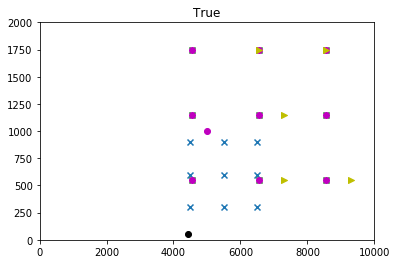

In [154]:
env = Environment(grid_x=3,grid_y=3)
env.car_speed *= 9
for i in range(10000):
    _, _, points = assign_targets(*env.get_data(), None, 0)
    if points.size == 0:
        break
#     print(points)
#     break
    env.step(points)
    plt.title(env.sending)
    env.visualize()
    plt.show()
    clear_output(True)

In [234]:
env.car_steps

array([ 0, 10, 13, 14])